<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/master/All_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloning Repo & installing libs

In [118]:
!rm -rf education-impact

In [119]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (390/390), done.
remote: Total 461 (delta 240), reused 207 (delta 68), pack-reused 0
Receiving objects: 100% (461/461), 6.39 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (240/240), done.


In [120]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

In [121]:
import pandas as pd
import os
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes

# Setting paths

In [5]:
root = "education-impact/datasets/" 
datasets_path = {
                    "infant_mortality"                :  root+ "Infant_Mortality_Rate.csv",
                    "child_mortality"                 :  root+ "child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                    "co2_emissions_percapita"         :  root+ "co2_emissions_tonnes_per_person.csv",
                    "population"                      :  root+ "converted_pop.csv",
                    "population_density"              :  root+ "population_per_area.csv",
                    "gdp_growth"                      :  root+ "gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"            :  root+ "mincpcap_cppp.csv",
                    "gdppercapita_us_infla_adjust"    :  root+ "gdppercapita_us_inflation_adjusted.csv",
                    "gini_index"                      :  root+ "gini.csv",
                    "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                    "poverty_index"                   :  root+ "mincpcap_cppp.csv",
                    "people_in_poverty"               :  root+ "number_of_people_in_poverty.csv",
                    "ratio_b/g_in_primary"            :  root+ "ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                     :  root+ "wcde-25--34.csv",
                    "20-24-In_Primary_OL"             :  root+ "In_Primary_OL.csv",
                    "20-24-Primary_OL"                :  root+ "Primary_OL.csv",
                    "20-24-Lower_Secondary_OL"        :  root+ "Lower_Secondary_OL.csv",
                    "20-24_female-In_Primary_OL"      :  root+ "female_In_Primary_OL.csv",
                    "20-24_female-Primary_OL"         :  root+ "female_Primary_OL.csv",
                    "20-24_female-Lower_Secondary_OL" :  root+ "female_Lower_Secondary_OL.csv",
                    "20-24-In_Primary_OL_comp"        :  root+ "In_Primary_OL_complete.csv",
                    "20-24-Primary_OL_comp"           :  root+ "Primary_OL_complete.csv",
                    "20-24-Lower_Secondary_OL_comp"   :  root+ "Lower_Secondary_OL_complete.csv",
                }

created_datasets = []

# Defining common functions

In [352]:
def get_countries_count(datasets):
  for dataset in datasets:
    df = pd.read_csv(datasets_path[dataset])
    count = len(set(df.Country.unique()))
    print(f"{'Factor: ' + dataset:<40} count: {count}")


In [353]:
def find_common_countries(datasets,o_dataset=None):
  common_countries = set()
  first_time = True
  for dataset in datasets:
    countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    if first_time:
      common_countries = countries_list
      first_time = False
    else:
      common_countries = common_countries.intersection(countries_list)
  if o_dataset !=None:
    countries_list = list(pd.read_csv(datasets_path[o_dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    common_countries = common_countries.intersection(countries_list)
  return list(common_countries)

In [354]:
def generate_indices(countries,years):
  keys=[]
  for y in years:
    for c in countries:
      keys.append((c,str(y)))
  return keys

In [355]:
def load_datasets_to_pd(datasets,keys,include_output=True,o_dataset=None):
  combined_df = pd.DataFrame(keys,columns=['country','year'])
  for dataset in datasets:
    print("loading " + dataset)
    combined_df = add_dataset(combined_df,dataset)
    

  if include_output:
    combined_df = add_dataset(combined_df,o_dataset,output = True)
  return combined_df

  

In [356]:
def add_dataset(input_df,dataset,output = False):
  label = dataset
  if output : 
    label = "o_"+OUTPUT
  input_df[label] = [math.nan]*len(input_df)
  df = pd.read_csv(datasets_path[dataset])
  df["Country"] = df["Country"].str.lower()
  df.set_index("Country", inplace=True)
  for e in range(len(input_df)):
    country = input_df.iloc[e].country
    year    = input_df.iloc[e].year
  
    if output:
      input_df.at[e,label] = df.loc[country][str( int(year) + PREDICT_FUTURE )]
    else:
      input_df.at[e,label] = df.loc[country][year]
    
  return input_df

In [357]:
def create_n_yrs_old_csv(dataset,n):
    table_name = str(n)+"_yrs_old_"+dataset
    # if table_name in created_datasets:
    #   return table_name
    df = pd.read_csv(datasets_path[dataset])
    years = list(range(1960, 2016))
    countries = list(df['Country'])
    new_df = pd.DataFrame(countries,columns=['Country'])
    for i in range(1960,2016):
      new_df[i] = np.nan
    new_df.set_index('Country',inplace=True)
    df.set_index('Country',inplace=True)
    for c in countries:
      for y in range(1960+n,2016):
        new_df[y].at[c] = df.loc[c][str(y-n)]
    
    
    datasets_path[table_name] = root+table_name+".csv"
    new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

    created_datasets.append(table_name)
    return table_name

In [358]:
def create_n_dropout_csv(dataset,n,s_n = 90):
    df = pd.read_csv(datasets_path[dataset])
    years = list(range(1875, 2016))
    countries = list(df['Country'])
    drop_out_years = []
    for i in range(len(df)):
      started = False
      s_year  = 1875
      for year in years:
        if not started and df.iloc[i][str(year)] < s_n :
          started = True
          s_year  = year
        elif started and df.iloc[i][str(year)] < n :
          drop_out_years.append((df.iloc[i]['Country'],(year-s_year)))
          break
      else:
        if started:
          drop_out_years.append((df.iloc[i]['Country'], 100))
        else:
          drop_out_years.append((df.iloc[i]['Country'], year-s_year))
    new_df = pd.DataFrame(countries,columns=['Country'])
    for i in years:
      new_df[i] = np.nan
    new_df.set_index('Country',inplace=True)
    for c,y in drop_out_years:
      for i in years:
        new_df.at[c,i] = y
    table_name = str(n)+"%_dropout_"+dataset
    datasets_path[table_name] = root+table_name+".csv"
    new_df = new_df[(new_df.T != 1).any()]
    new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

    created_datasets.append(table_name)
    return table_name

In [359]:
def combine_dfs(X,y):
  label = y.columns[0]
  X[label] = y
  X.dropna(subset=[label],inplace=True)
  return X

In [360]:
def extract_variable_imp(variable):
  v_list = inspector.variable_importances()[variable]
  v = variable + "\n"

  for i in range(0,len(v_list)):
    if v_list[0][0]!='_':
      v += str(i)+ "  "
      v += f"{v_list[i][0][0]:<50}" 
      v += str(v_list[i][1]) + "\n"
  return v

In [361]:
def rate_of_dropout(dataset,n):
  table_name = str(n)+"_yr_period_rate_of_change_of_"+dataset

  years  = [y for y in range(1960,2016)]
  edu_df = pd.read_csv(datasets_path[dataset])
  countries = list(edu_df['Country'])
  new_df = pd.DataFrame(countries,columns=['Country'])
  for i in years:
    new_df[i] = np.nan
  new_df.set_index('Country',inplace=True)
  edu_df.set_index('Country',inplace=True)
  for c in countries:
    for y in range(1960+n,2016):
      new_df[y].at[c] = (edu_df.loc[c][str(y-n)] - edu_df.loc[c][str(y)])/n

  datasets_path[table_name] = root+table_name+".csv"
  
  new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

  created_datasets.append(table_name)
  return table_name




# Plotting Data

In [ ]:
datasets_to_plot = [
            "infant_mortality",
            "child_mortality",
            "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
            "population",
            "population_density",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL",
            "life_expectancy"
            ]

# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
years       = [y for y in range(1960,2016)]
keys        = generate_indices(countries, years)

combined_df = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)

## Life Expectancy

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'life_expectancy'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## Total Fertility Rate

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'children_per_woman
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## Primary education OL

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = '20-24-Primary_OL'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## GDP per capita

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'gdppercapita_us_infla_adjust'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

# Building Model

## Life Expectancy

### Preparing the Data

In [257]:
PREDICT_FUTURE  = 0
OUTPUT         = 'life_expectancy'

In [258]:
datasets = [
            # "infant_mortality",
            # "life_expectancy",
            # "child_mortality",
            "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: children_per_woman               count: 202
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: 50%_dropout_20-24-Primary_OL_comp count: 180
Factor: 20-24-In_Primary_OL              count: 202
Factor: 20-24-Primary_OL                 count: 202
Factor: population                       count: 197
Factor: 20-24_female-In_Primary_OL       count: 202
Factor: 20-24_female-Primary_OL          count: 202


In [259]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
countries.sort()
countries

In [262]:
input_df            = load_datasets_to_pd(datasets,OUTPUT,keys)
input_df.set_index(["country","year"], inplace=True)

loading children_per_woman
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading 50%_dropout_20-24-Primary_OL_comp
loading 20-24-In_Primary_OL
loading 20-24-Primary_OL
loading population
loading 20-24_female-In_Primary_OL
loading 20-24_female-Primary_OL


In [263]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [264]:
input_df

,,children_per_woman,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,20_yrs_old_gdppercapita_us_infla_adjust,50%_dropout_20-24-Primary_OL_comp,20-24-In_Primary_OL,20-24-Primary_OL,population,20-24_female-In_Primary_OL,20-24_female-Primary_OL
country,year,,,,,,,,,,,
finland,1960,2.71,3.400,34.1,11400.0,NaN,81.0,0.0,41.4,4430000.0,0.0,39.7
sao tome and principe,1960,6.24,0.171,32.1,NaN,NaN,100.0,98.4,99.2,64300.0,98.6,99.1
israel,1960,3.84,3.140,34.9,NaN,NaN,91.0,30.9,58.1,2060000.0,36.4,61.9
bulgaria,1960,2.25,2.830,22.5,NaN,NaN,39.0,3.3,12.5,7890000.0,4.5,15.4
costa rica,1960,6.45,0.369,47.1,3600.0,NaN,75.0,48.6,77.1,1330000.0,49.8,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...
new zealand,2015,2.01,7.770,34.5,38600.0,28000.0,50.0,1.1,4.5,4610000.0,1.0,3.8
armenia,2015,1.66,1.650,31.9,3610.0,959.0,15.0,0.2,1.0,2930000.0,0.2,0.9
samoa,2015,4.03,1.210,42.1,4070.0,2780.0,38.0,0.7,17.1,194000.0,0.5,13.6


In [265]:
output_df

,,o_life_expectancy
country,year,
finland,1960,69.2
sao tome and principe,1960,45.0
israel,1960,71.8
bulgaria,1960,69.4
costa rica,1960,65.3
...,...,...
new zealand,2015,81.7
armenia,2015,75.1
samoa,2015,70.1


In [266]:
input_df.isna().sum()

children_per_woman                            0
co2_emissions_percapita                     177
gini_index                                    0
gdppercapita_us_infla_adjust               1955
20_yrs_old_gdppercapita_us_infla_adjust    5141
50%_dropout_20-24-Primary_OL_comp             0
20-24-In_Primary_OL                           0
20-24-Primary_OL                              0
population                                    0
20-24_female-In_Primary_OL                    0
20-24_female-Primary_OL                       0
dtype: int64

In [267]:
input_df.shape

(9072, 11)

In [268]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

### Random Forest Model

In [269]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpjdfgn8s9 as temporary training directory
Starting reading the dataset
5/7 [====================>.........] - ETA: 0s
Dataset read in 0:00:00.272402
Training model
Model trained in 0:00:06.588970
Compiling model
7/7 [==============================] - 1s 63ms/step - loss: 0.0000e+00 - mse: 1.5261
LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 1.5261439085006714}

MSE: 1.5261439085006714
RMSE: 1.2353719717156737



In [270]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [271]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	20_yrs_old_gdppercapita_us_infla_adjust
	50__dropout_20-24-Primary_OL_comp
	children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL" 11.779436 ################
    2.       "50__dropout_20-24-Primary_OL_comp"  8.967458 ###########
    3.                     "20-24-In_Primary_OL"  8.224354 ##########
    4.                        "20-24-Primary_OL"  8.196749 ##########
    5. "20_yrs_old_gdppercapi

### Gradient Tree

In [272]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmp9lz8shv_ as temporary training directory
Starting reading the dataset
1/7 [===>..........................] - ETA: 1s
Dataset read in 0:00:00.233088
Training model
Model trained in 0:00:05.755307
Compiling model
7/7 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mse: 1.2303
LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 1.2302955389022827}

MSE: 1.2302955389022827
RMSE: 1.1091868818653972



In [273]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [274]:
model.summary()

Model: "gradient_boosted_trees_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	20_yrs_old_gdppercapita_us_infla_adjust
	50__dropout_20-24-Primary_OL_comp
	children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.758480 ################
    2.              "20-24_female-In_Primary_OL"  4.059269 ########
    3. "20_yrs_old_gdppercapita_us_infla_adjust"  4.040414 ########
    4.                        "20-24-Primary_OL"  4.017151 ########
    5.            

## Total Fertility Rate

In [275]:
PREDICT_FUTURE  = 0
OUTPUT         = 'children_per_woman'

In [276]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 50%_dropout_20-24-Primary_OL_comp count: 180
Factor: 20-24-In_Primary_OL              count: 202
Factor: 20-24-Primary_OL                 count: 202
Factor: population                       count: 197
Factor: 20-24_female-In_Primary_OL       count: 202
Factor: 20-24_female-Primary_OL          count: 202


In [277]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [279]:
input_df            = load_datasets_to_pd(datasets,OUTPUT,keys)
# input_df            = add_n_yrs_old_dataset(input_df,"gdppercapita_us_infla_adjust",20)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading 20_yrs_old_children_per_woman
loading 50%_dropout_20-24-Primary_OL_comp
loading 20-24-In_Primary_OL
loading 20-24-Primary_OL
loading population
loading 20-24_female-In_Primary_OL
loading 20-24_female-Primary_OL


In [280]:
input_df

,,life_expectancy,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,20_yrs_old_gdppercapita_us_infla_adjust,20_yrs_old_children_per_woman,50%_dropout_20-24-Primary_OL_comp,20-24-In_Primary_OL,20-24-Primary_OL,population,20-24_female-In_Primary_OL,20-24_female-Primary_OL
country,year,,,,,,,,,,,,
finland,1960,69.2,3.400,34.1,11400.0,NaN,NaN,81.0,0.0,41.4,4430000.0,0.0,39.7
sao tome and principe,1960,45.0,0.171,32.1,NaN,NaN,NaN,100.0,98.4,99.2,64300.0,98.6,99.1
israel,1960,71.8,3.140,34.9,NaN,NaN,NaN,91.0,30.9,58.1,2060000.0,36.4,61.9
bulgaria,1960,69.4,2.830,22.5,NaN,NaN,NaN,39.0,3.3,12.5,7890000.0,4.5,15.4
costa rica,1960,65.3,0.369,47.1,3600.0,NaN,NaN,75.0,48.6,77.1,1330000.0,49.8,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
new zealand,2015,81.7,7.770,34.5,38600.0,28000.0,2.11,50.0,1.1,4.5,4610000.0,1.0,3.8
armenia,2015,75.1,1.650,31.9,3610.0,959.0,1.80,15.0,0.2,1.0,2930000.0,0.2,0.9
samoa,2015,70.1,1.210,42.1,4070.0,2780.0,4.75,38.0,0.7,17.1,194000.0,0.5,13.6


In [287]:
output_df

,,o_children_per_woman
country,year,
finland,1960,2.71
sao tome and principe,1960,6.24
israel,1960,3.84
bulgaria,1960,2.25
costa rica,1960,6.45
...,...,...
new zealand,2015,2.01
armenia,2015,1.66
samoa,2015,4.03


In [281]:
input_df.isna().sum()

life_expectancy                               0
co2_emissions_percapita                     177
gini_index                                    0
gdppercapita_us_infla_adjust               1955
20_yrs_old_gdppercapita_us_infla_adjust    5141
20_yrs_old_children_per_woman              3240
50%_dropout_20-24-Primary_OL_comp             0
20-24-In_Primary_OL                           0
20-24-Primary_OL                              0
population                                    0
20-24_female-In_Primary_OL                    0
20-24_female-Primary_OL                       0
dtype: int64

In [282]:
input_df.shape

(9072, 12)

In [283]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

### Random Forest

In [284]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpx0u8ucz1 as temporary training directory
Starting reading the dataset
1/7 [===>..........................] - ETA: 1s
Dataset read in 0:00:00.299140
Training model
Model trained in 0:00:06.050874
Compiling model
7/7 [==============================] - 1s 83ms/step - loss: 0.0000e+00 - mse: 0.0330
CHILDREN_PER_WOMAN
{'loss': 0.0, 'mse': 0.03301648423075676}

MSE: 0.03301648423075676
RMSE: 0.1817043869331634



In [285]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [286]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	50__dropout_20-24-Primary_OL_comp
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL" 11.629898 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  9.239242 ###########
    3.            "gdppercapita_us_infla_adjust"  8.856034 ##########
    4.                 "co2_emissions_percapita"  8.511697 #########
  

### Gradient Tree

In [288]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpwakif2we as temporary training directory
Starting reading the dataset
6/7 [========================>.....] - ETA: 0s
Dataset read in 0:00:00.312118
Training model
Model trained in 0:00:05.975016
Compiling model
7/7 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mse: 0.0289
CHILDREN_PER_WOMAN
{'loss': 0.0, 'mse': 0.028871363028883934}

MSE: 0.028871363028883934
RMSE: 0.16991575273906753



In [289]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [290]:
model.summary()

Model: "gradient_boosted_trees_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	50__dropout_20-24-Primary_OL_comp
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.740495 ################
    2.              "20-24_female-In_Primary_OL"  4.174140 #########
    3. "20_yrs_old_gdppercapita_us_infla_adjust"  4.095882 ########
    4.                        "20-24-Primary_OL"  4.05843

## Primary education OL

In [385]:
PREDICT_FUTURE = 0
OUTPUT         = '20-24-Primary_OL'


In [407]:
datasets = [
            "infant_mortality",
            "life_expectancy",
            "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            "population",
            create_n_yrs_old_csv('20-24-Primary_OL',n = 20),
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            
            ]
get_countries_count(datasets)

Factor: infant_mortality                 count: 266
Factor: life_expectancy                  count: 195
Factor: child_mortality                  count: 197
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: population                       count: 197
Factor: 20_yrs_old_20-24-Primary_OL      count: 202


In [408]:
# creating a list of all countries & years
countries = find_common_countries(datasets,OUTPUT)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [409]:
input_df            = load_datasets_to_pd(datasets,OUTPUT,keys)
# input_df.dropna(subset=["gdppercapita_us_infla_adjust"],inplace=True)
input_df.set_index(["country","year"], inplace=True)

loading infant_mortality
loading life_expectancy
loading child_mortality
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading population
loading 20_yrs_old_20-24-Primary_OL


In [410]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [411]:
input_df

,,infant_mortality,life_expectancy,child_mortality,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,20_yrs_old_gdppercapita_us_infla_adjust,population,20_yrs_old_20-24-Primary_OL
country,year,,,,,,,,,
dominican republic,1960,102.1,61.9,147.00,0.316,42.3,1380.0,NaN,3290000.0,NaN
finland,1960,21.9,69.2,26.90,3.400,34.1,11400.0,NaN,4430000.0,NaN
sao tome and principe,1960,NaN,45.0,144.00,0.171,32.1,NaN,NaN,64300.0,NaN
israel,1960,34.5,71.8,40.10,3.140,34.9,NaN,NaN,2060000.0,NaN
bulgaria,1960,45.0,69.4,66.80,2.830,22.5,NaN,NaN,7890000.0,NaN
...,...,...,...,...,...,...,...,...,...,...
samoa,2015,14.5,70.1,17.20,1.210,42.1,4070.0,2780.0,194000.0,35.5
afghanistan,2015,53.2,61.9,70.40,0.262,36.8,578.0,NaN,34400000.0,96.3
united kingdom,2015,3.8,81.0,4.45,6.420,33.4,45000.0,32700.0,65900000.0,0.0


In [403]:
input_df.isna().sum()

infant_mortality                            901
life_expectancy                               0
child_mortality                               0
gini_index                                    0
gdppercapita_us_infla_adjust               2171
20_yrs_old_gdppercapita_us_infla_adjust    5617
population                                    0
20_yrs_old_20-24-Primary_OL                3520
dtype: int64

In [299]:
input_df.shape

(9856, 10)

In [412]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

### RF

In [413]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmp8xikd_zj as temporary training directory
Starting reading the dataset
7/7 [==============================] - ETA: 0s
Dataset read in 0:00:00.288890
Training model
Model trained in 0:00:05.680881
Compiling model
7/7 [==============================] - 1s 79ms/step - loss: 0.0000e+00 - mse: 16.9906
20-24-PRIMARY_OL
{'loss': 0.0, 'mse': 16.99055290222168}

MSE: 16.99055290222168
RMSE: 4.121959837531375



In [395]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [406]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (8):
	20_yrs_old_20-24-Primary_OL
	20_yrs_old_gdppercapita_us_infla_adjust
	child_mortality
	gdppercapita_us_infla_adjust
	gini_index
	infant_mortality
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL" 11.853509 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  9.423533 ############
    3.                              "population"  7.459277 ########
    4.            "gdppercapita_us_infla_adjust"  6.807799 #######
    5.                              "gini_index"  6.193678 ######
    6.                        "infant_mortality"  5.961521

### Gradient Tree

In [397]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpu4_ou9t3 as temporary training directory
Starting reading the dataset
6/7 [========================>.....] - ETA: 0s
Dataset read in 0:00:00.275490
Training model
Model trained in 0:00:05.594561
Compiling model
7/7 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mse: 19.1987
20-24-PRIMARY_OL
{'loss': 0.0, 'mse': 19.198705673217773}

MSE: 19.198705673217773
RMSE: 4.381632763390581



In [398]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [399]:
model.summary()

Model: "gradient_boosted_trees_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (9):
	20_yrs_old_20-24-Primary_OL
	20_yrs_old_gdppercapita_us_infla_adjust
	child_mortality
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	infant_mortality
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.755796 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  4.396351 ############
    3.                        "infant_mortality"  3.721016 ######
    4.                         "child_mortality"  3.711544 ######
    5.                         "life_expectancy"  3.704528 ######
    6.             

In [ ]:
for f in created_datasets:
  if os.path.isfile(datasets_path[f]): # this makes the code more robust
        # os.remove(datasets_path[f])

## GDP per capita

### Preparing the data

In [195]:
PREDICT_FUTURE  = 0
OUTPUT         = 'gdppercapita_us_infla_adjust'


In [338]:
datasets = [
            # "infant_mortality",
            # "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            "gini_index",
            create_n_yrs_old_csv("infant_mortality",n = 20),
            # create_n_yrs_old_csv("life_expectancy",n = 20),
            # create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("20-24-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24-Primary_OL",n = 20),
            create_n_yrs_old_csv("20-24-Lower_Secondary_OL",n = 20),
            # create_n_yrs_old_csv("20-24_female-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24_female-Primary_OL",n = 20),
            # "gdp_growth",
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # rate_of_dropout("20-24-Primary_OL",5),
            # "20-24-In_Primary_OL",
            # "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: gini_index                       count: 195
Factor: 20_yrs_old_infant_mortality      count: 266
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: 20_yrs_old_20-24-Lower_Secondary_OL count: 202
Factor: population                       count: 197


In [339]:
# creating a list of all countries & years
countries = find_common_countries(datasets,OUTPUT)
years     = [y for y in range(1980,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [340]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True) 
# input_df['o_gdppercapita_us_infla_adjust'] = np.log(input_df['o_gdppercapita_us_infla_adjust'])
# input_df['20_yrs_old_gdppercapita_us_infla_adjust'] = np.log(input_df['20_yrs_old_gdppercapita_us_infla_adjust'])

loading gini_index
loading 20_yrs_old_infant_mortality
loading 20_yrs_old_children_per_woman
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading 20_yrs_old_20-24-Lower_Secondary_OL
loading population


In [341]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [342]:
print(input_df.shape)
input_df.isna().sum()

(6336, 6)


gini_index                                    0
20_yrs_old_infant_mortality                 901
20_yrs_old_children_per_woman                 0
20_yrs_old_gdppercapita_us_infla_adjust    2097
20_yrs_old_20-24-Lower_Secondary_OL           0
population                                    0
dtype: int64

In [180]:
input_df.describe()

,gini_index,20_yrs_old_infant_mortality,20_yrs_old_life_expectancy,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,gdp_growth,20-24-In_Primary_OL,20-24-Primary_OL,20-24-Lower_Secondary_OL,population,20-24_female-Primary_OL
count,9856.000000,5435.000000,6336.000000,6336.000000,6336.000000,9848.000000,9856.000000,9856.000000,9856.000000,9.856000e+03,9856.000000
mean,39.678155,68.361840,62.380193,109.496630,4.723515,2.061148,28.610288,42.829728,64.128034,2.860715e+07,45.114154
std,9.833643,50.617856,9.826351,90.499713,2.020725,6.698984,30.973840,34.189538,31.199226,1.104936e+08,36.423003
min,16.000000,4.000000,9.500000,4.830000,1.210000,-67.500000,0.000000,0.000000,0.000000,4.120000e+04,0.000000
25%,32.500000,23.700000,54.600000,30.600000,2.650000,-0.169000,1.020000,5.995000,38.345000,1.690000e+06,5.815000
50%,39.900000,56.600000,64.500000,82.000000,5.130000,2.140000,15.390000,42.190000,72.200000,5.490000e+06,42.770000
75%,45.100000,105.550000,70.500000,174.000000,6.550000,4.460000,53.910000,74.900000,93.300000,1.660000e+07,81.800000
max,77.000000,279.700000,80.200000,423.000000,8.870000,145.000000,99.900000,100.000000,100.100000,1.410000e+09,100.000000


In [307]:
input_df

,,gini_index,20_yrs_old_infant_mortality,20_yrs_old_life_expectancy,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,20_yrs_old_gdppercapita_us_infla_adjust,20_yrs_old_20-24-In_Primary_OL,20_yrs_old_20-24-Primary_OL,20_yrs_old_20-24-Lower_Secondary_OL,20_yrs_old_20-24_female-In_Primary_OL,20_yrs_old_20-24_female-Primary_OL,gdp_growth,population
country,year,,,,,,,,,,,,,
djibouti,1980,36.5,NaN,56.2,250.00,6.46,NaN,0.0,0.0,0.0,0.0,0.0,-1.550,359000.0
nepal,1980,30.7,216.4,44.6,322.00,5.96,328.0,90.5,94.7,99.8,97.5,98.7,-4.760,15000000.0
greece,1980,37.5,39.5,72.4,46.30,2.33,5030.0,18.8,68.3,87.6,25.4,74.5,0.904,9630000.0
gambia,1980,39.6,152.5,53.9,361.00,5.57,NaN,95.9,96.8,100.0,97.3,98.0,-12.800,637000.0
denmark,1980,27.5,21.3,72.5,25.00,2.54,18100.0,0.1,0.2,71.7,0.2,0.4,-0.431,5120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
germany,2015,31.6,5.3,76.9,6.46,1.31,31600.0,0.0,3.6,25.2,0.0,3.9,1.450,81800000.0
ukraine,2015,24.8,17.3,67.0,20.30,1.41,1920.0,0.3,0.6,24.2,0.3,0.3,NaN,44900000.0
barbados,2015,43.8,13.7,73.9,15.20,1.73,14000.0,0.0,0.0,0.0,0.0,0.0,0.640,285000.0


### Random Forest

In [308]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_test,y_test), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmp8spt3wfz as temporary training directory
Starting reading the dataset
5/6 [========================>.....] - ETA: 0s
Dataset read in 0:00:00.315376
Training model
Model trained in 0:00:07.006078
Compiling model
6/6 [==============================] - 8s 2s/step


Evaluation(num_examples=5701, accuracy=None, loss=None, rmse=3165.1150308735528, ndcg=None, aucs=None)

In [162]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [309]:
# %set_cell_height 300

model.summary()


Model: "random_forest_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (13):
	20_yrs_old_20-24-In_Primary_OL
	20_yrs_old_20-24-Lower_Secondary_OL
	20_yrs_old_20-24-Primary_OL
	20_yrs_old_20-24_female-In_Primary_OL
	20_yrs_old_20-24_female-Primary_OL
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	20_yrs_old_infant_mortality
	20_yrs_old_life_expectancy
	gdp_growth
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL" 11.978161 ################
    2.                              "gdp_growth" 11.016276 ##############
    3.                              "gini_index"  9.875954 #######

### Gradient Tree

In [345]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_test,y_test), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
# print()
model.make_inspector().evaluation()

Use /tmp/tmp3gqqt6ya as temporary training directory
Starting reading the dataset
1/6 [====>.........................] - ETA: 1s
Dataset read in 0:00:00.235292
Training model
Model trained in 0:00:03.447913
Compiling model
6/6 [==============================] - 4s 703ms/step


Evaluation(num_examples=None, accuracy=None, loss=2634.038818359375, rmse=2634.038818359375, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [346]:
model.summary()

Model: "gradient_boosted_trees_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	20_yrs_old_20-24-Lower_Secondary_OL
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	20_yrs_old_infant_mortality
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.741736 ################
    2.     "20_yrs_old_20-24-Lower_Secondary_OL"  3.625812 ########
    3.             "20_yrs_old_infant_mortality"  3.239603 #####
    4.                              "gini_index"  3.224106 #####
    5. "20_yrs_old_gdppercapita_us_infla_adjust"  2.961845 ####
    6.           "20_yrs_old_children_per_woman"  2.782147 ##
   

# Building Model for Best Performing Countries

## Preparing DataFrames of Top Performing Countries

In [18]:
try:
  os.mkdir(root+"best_performers")
except:
  pass

### Life Expectany

In [19]:
le_threshold_percentile = 85
le_start_percentile = 60    # it means consider bottom 60% of countries
le_parameter = 'life_expectancy'

In [20]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4]
le_pd = pd.read_csv(datasets_path[le_parameter])
describe = le_pd.describe(percentiles = percentiles)

le_pd.reset_index(inplace=True, drop=True)
le_pd.set_index(["Country"],inplace=True)
sk_start_value = le_pd.loc['South Korea']['1960']


In [21]:
for i in percentiles:
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']>sk_start_value:
    start_value = describe.loc[s_index]['1960']
    break
start_value

70.4

In [22]:
start_value = describe.loc[str(le_start_percentile)+"%"]["1960"]

In [23]:
undeveloped_countries_pd = le_pd.loc[le_pd['1960'] < start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,45.0,45.3,45.5,45.7,45.9,46.1,46.3,46.5,46.7,46.9,47.1,47.3,47.3,47.3,47.4,47.5,47.7,47.9,46.4,44.7,43.7,44.3,44.1,42.3,39.9,42.0,43.3,45.9,48.5,52.7,53.8,53.8,54.2,54.4,53.9,54.3,54.7,54.5,53.3,54.7,54.7,54.8,55.5,56.5,57.1,57.6,58.0,58.5,59.2,59.9,60.5,61.0,61.4,61.9,61.9,61.9
Angola,46.3,44.8,45.0,45.2,45.4,45.6,45.8,46.0,46.2,46.4,46.6,46.8,47.0,47.2,47.4,47.5,47.5,47.7,47.8,48.0,48.1,48.2,48.2,48.2,48.4,48.6,48.6,48.6,48.6,49.4,49.7,50.3,50.3,49.0,50.3,51.2,51.7,51.6,50.6,51.9,52.8,53.4,54.5,55.1,55.5,56.4,57.0,58.0,58.8,59.5,60.2,60.8,61.4,62.1,63.0,63.5
United Arab Emirates,60.3,60.8,61.3,61.6,62.1,62.6,63.0,63.4,63.8,64.2,64.0,64.9,65.1,65.4,65.7,66.0,66.3,66.6,67.0,67.3,67.6,68.0,68.1,67.9,68.4,68.5,68.5,68.5,68.5,68.6,68.7,68.7,68.8,68.8,68.7,68.8,68.9,69.0,69.2,69.2,69.1,69.2,69.4,69.3,69.1,69.2,69.5,70.0,70.4,70.6,70.8,71.0,71.2,71.6,73.0,73.2
Armenia,59.2,60.4,61.4,62.0,62.9,63.6,64.2,64.7,65.1,65.3,65.9,66.4,66.8,67.2,67.9,68.2,69.0,69.5,69.7,70.2,70.2,70.5,70.8,70.8,71.1,71.3,71.7,71.8,55.3,71.0,70.6,70.3,69.4,69.0,69.5,70.1,70.4,71.1,71.6,71.9,72.4,72.5,72.7,72.8,73.0,73.0,73.1,73.5,73.5,73.6,73.9,74.2,74.6,75.1,75.2,75.1
Azerbaijan,48.6,50.2,51.7,53.1,54.4,55.6,56.6,57.5,58.2,58.4,59.9,61.0,61.9,62.8,63.7,64.3,65.2,65.3,64.8,65.6,66.2,66.3,66.6,66.8,66.8,66.9,66.9,66.8,66.8,67.0,66.9,66.3,64.5,64.3,63.8,64.7,65.3,65.7,66.0,66.2,66.5,67.1,67.2,67.1,67.2,67.3,67.7,68.2,68.5,68.8,69.0,69.2,69.5,69.7,69.9,70.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,60.7,61.1,61.3,61.4,57.2,61.3,61.3,61.8,62.0,62.2,62.4,62.6,63.0,63.2,63.3,63.6,64.1,64.4,64.7,65.0,65.2,65.4,65.5,65.7,65.8,66.0,66.2,66.4,66.6,66.8,66.9,66.9,67.2,67.4,67.5,67.7,67.8,68.0,68.2,68.3,68.5,68.6,68.8,68.9,69.0,69.0,69.2,69.3,69.5,67.5,69.6,69.7,69.6,69.9,70.0,70.1
Yemen,36.5,37.1,36.3,36.9,37.6,38.2,38.8,39.4,40.2,41.0,41.9,44.3,45.4,46.6,47.6,48.7,49.8,50.9,51.8,52.6,53.3,54.0,54.3,55.5,56.1,56.7,55.2,57.7,58.2,58.6,59.1,59.5,59.9,60.3,60.5,61.1,61.5,62.0,62.5,63.0,63.5,64.0,64.5,64.9,65.3,65.8,66.2,66.5,66.9,67.2,67.6,67.8,67.9,68.4,68.5,68.2
South Africa,53.9,54.2,54.4,54.6,54.9,55.2,55.5,55.8,56.1,56.4,56.7,57.0,57.3,57.6,58.0,58.3,58.6,58.8,59.1,59.3,59.5,59.8,60.2,60.5,61.3,61.9,62.1,62.8,63.5,63.8,64.2,64.3,63.6,64.3,63.4,62.9,61.8,59.5,58.0,57.2,55.6,54.8,53.7,52.7,52.2,52.1,52.3,53.2,54.3,55.7,57.1,58.7,60.1,61.3,61.8,62.3


In [24]:
le_threshold_value = undeveloped_countries_pd.describe(percentiles=[le_threshold_percentile/100]).loc[str(le_threshold_percentile)+"%"]["2015"]
le_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] > le_threshold_value]
le_fast_growing_nations = le_fast_growing_nations.append(le_pd.loc['Singapore'])
le_fast_growing_nations = le_fast_growing_nations.append(le_pd.loc['India'])
le_fast_growing_nations

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Armenia,59.2,60.4,61.4,62.0,62.9,63.6,64.2,64.7,65.1,65.3,65.9,66.4,66.8,67.2,67.9,68.2,69.0,69.5,69.7,70.2,70.2,70.5,70.8,70.8,71.1,71.3,71.7,71.8,55.3,71.0,70.6,70.3,69.4,69.0,69.5,70.1,70.4,71.1,71.6,71.9,72.4,72.5,72.7,72.8,73.0,73.0,73.1,73.5,73.5,73.6,73.9,74.2,74.6,75.1,75.2,75.1
Bahrain,57.3,58.1,58.8,59.5,60.2,60.9,61.5,62.1,62.9,63.5,64.2,64.9,65.4,66.0,66.4,66.8,67.2,67.5,66.9,68.2,68.4,68.7,69.0,69.2,69.2,69.4,69.0,69.4,69.4,69.5,69.5,69.5,69.8,70.1,70.3,70.5,70.7,70.9,71.0,71.2,71.7,73.4,72.7,72.2,72.3,72.7,73.0,73.6,74.0,74.5,75.0,75.3,75.7,76.2,76.6,76.8
Chile,54.2,57.5,56.8,57.1,57.6,58.7,59.2,60.2,61.0,61.5,62.0,62.6,62.3,63.2,64.9,66.2,66.2,67.2,68.2,68.6,69.4,70.5,71.0,70.9,71.3,72.0,72.6,73.2,73.2,73.2,73.4,74.2,74.7,75.0,75.2,75.3,75.5,76.0,76.2,76.5,76.9,77.0,77.4,77.4,77.6,77.9,78.2,78.4,78.7,78.6,78.6,79.0,79.2,79.3,79.5,79.6
China,27.8,40.8,53.5,57.4,57.9,58.5,59.0,59.5,59.9,60.4,60.9,61.4,61.9,62.4,62.5,62.8,62.6,63.5,63.8,64.0,64.4,64.7,65.3,65.7,66.1,66.6,67.1,67.3,67.5,67.7,68.1,68.4,68.7,69.0,69.4,69.8,70.1,70.5,70.9,71.2,71.3,71.7,72.0,72.3,72.5,73.0,73.7,74.2,74.3,74.7,74.9,75.3,75.7,76.1,76.4,76.8
Colombia,59.3,59.5,60.1,60.9,61.5,61.6,62.1,62.4,63.1,64.4,65.9,65.9,65.1,64.9,65.3,66.3,66.8,67.8,68.2,68.5,68.9,69.2,69.6,69.8,70.2,67.2,70.2,70.2,70.6,70.8,71.5,71.0,71.1,71.7,72.1,72.5,72.8,73.5,74.0,74.1,74.2,74.4,73.4,75.2,75.6,76.5,76.7,77.3,77.6,77.5,77.9,78.7,79.0,79.3,79.7,79.7
Algeria,52.4,51.5,51.5,55.8,56.7,56.8,56.2,56.1,56.1,56.1,56.2,56.2,56.3,56.5,56.7,56.9,57.1,57.8,58.2,58.8,58.7,59.9,60.8,62.3,63.3,64.7,65.5,66.0,66.6,67.1,67.5,67.9,68.3,68.6,68.7,69.0,69.6,69.7,70.2,70.7,71.0,71.3,71.8,72.0,72.6,72.9,73.3,73.6,73.9,74.2,74.5,74.7,74.9,75.1,75.3,75.4
Ecuador,56.1,57.2,57.7,58.2,59.3,59.8,60.0,60.4,60.9,60.8,61.4,62.0,62.2,62.5,63.2,64.1,64.8,65.7,66.0,66.7,67.0,67.9,68.4,68.3,69.1,69.9,70.4,69.1,70.8,71.5,72.0,71.5,72.1,72.5,73.2,73.6,73.5,74.2,74.1,74.2,74.5,75.0,74.1,73.9,73.9,73.6,73.6,73.7,73.8,74.1,74.3,74.9,74.9,75.2,75.6,75.9
Iran,44.5,45.3,45.4,47.0,47.8,48.7,49.6,50.4,51.0,53.1,54.5,56.0,57.1,58.9,60.2,61.5,62.6,63.5,62.6,64.6,64.7,64.8,64.4,65.2,66.2,66.3,65.2,66.5,66.8,68.1,66.7,68.9,69.3,69.6,70.0,70.4,70.7,70.9,71.3,71.6,71.9,72.2,72.5,71.8,73.2,73.5,74.0,74.4,74.8,75.1,75.5,75.8,76.0,76.2,76.5,76.7
Jordan,59.4,59.6,60.0,60.1,60.9,61.4,61.4,61.6,62.9,63.5,63.0,64.4,64.8,65.2,65.3,65.4,65.7,66.3,66.5,66.7,67.1,67.5,67.6,68.1,68.7,69.1,69.0,69.6,70.3,70.7,71.2,71.4,71.8,71.6,71.7,71.8,71.8,72.0,72.3,72.5,72.9,73.0,73.3,73.8,74.0,74.1,74.5,75.5,76.2,76.7,76.9,77.2,77.5,77.9,78.1,78.2


### Total Fertility

In [25]:
tfr_threshold_percentile = 15
tfr_start_percentile = 60 # it means consider bottom 60% of countries
tfr_parameter = 'children_per_woman'
tfr_start_percentile = 100 - tfr_start_percentile

In [26]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[tfr_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea']['1960']

In [27]:
for i in reversed(percentiles):
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']<sk_start_value:
    start_value = describe.loc[s_index]['1960']
print(start_value)

5.79


In [28]:
start_value = describe.loc[str(tfr_start_percentile)+"%"]["1960"]
start_value

5.79

In [29]:
undeveloped_countries_pd = re_pd.loc[re_pd['1960'] > start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.46,7.46,7.46,7.46,7.46,7.46,7.47,7.48,7.50,7.54,7.57,7.61,7.63,7.64,7.62,7.57,7.49,7.39,7.27,7.14,6.99,6.83,6.65,6.46,6.25,6.04,5.82,5.60,5.38,5.17,4.98,4.80
Angola,7.48,7.52,7.56,7.59,7.61,7.62,7.62,7.61,7.61,7.60,7.60,7.60,7.61,7.61,7.61,7.62,7.61,7.59,7.57,7.54,7.50,7.47,7.44,7.41,7.39,7.38,7.37,7.35,7.32,7.29,7.25,7.19,7.13,7.06,6.99,6.92,6.85,6.79,6.73,6.68,6.64,6.60,6.57,6.54,6.50,6.47,6.42,6.37,6.31,6.24,6.16,6.08,6.00,5.92,5.84,5.77
Albania,6.49,6.40,6.28,6.13,5.96,5.77,5.58,5.39,5.22,5.06,4.91,4.78,4.64,4.51,4.37,4.24,4.10,3.97,3.84,3.73,3.62,3.53,3.45,3.38,3.32,3.27,3.22,3.16,3.11,3.05,2.98,2.91,2.83,2.75,2.67,2.59,2.51,2.42,2.33,2.25,2.16,2.07,1.98,1.90,1.82,1.75,1.70,1.67,1.65,1.65,1.65,1.67,1.69,1.70,1.71,1.71
United Arab Emirates,6.93,6.91,6.89,6.88,6.86,6.84,6.82,6.79,6.76,6.71,6.66,6.58,6.48,6.37,6.25,6.11,5.97,5.84,5.72,5.60,5.51,5.42,5.35,5.28,5.22,5.14,5.05,4.93,4.80,4.64,4.45,4.25,4.04,3.83,3.62,3.42,3.23,3.06,2.91,2.77,2.64,2.53,2.43,2.33,2.24,2.15,2.07,2.01,1.95,1.90,1.87,1.84,1.82,1.80,1.78,1.77
Azerbaijan,5.88,5.94,5.96,5.95,5.89,5.79,5.66,5.51,5.35,5.19,5.02,4.85,4.68,4.51,4.34,4.18,4.02,3.87,3.73,3.61,3.50,3.41,3.34,3.29,3.26,3.24,3.22,3.20,3.18,3.14,3.09,3.02,2.93,2.82,2.71,2.58,2.45,2.33,2.21,2.11,2.03,1.96,1.91,1.87,1.84,1.82,1.82,1.84,1.87,1.91,1.96,2.01,2.05,2.08,2.09,2.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,7.65,7.65,7.63,7.60,7.57,7.52,7.46,7.40,7.33,7.27,7.19,7.12,7.04,6.95,6.86,6.76,6.66,6.55,6.43,6.32,6.20,6.09,5.97,5.85,5.73,5.62,5.51,5.40,5.30,5.21,5.12,5.03,4.96,4.88,4.82,4.75,4.69,4.64,4.59,4.54,4.50,4.48,4.46,4.45,4.46,4.46,4.46,4.45,4.43,4.39,4.34,4.28,4.21,4.15,4.09,4.03
Yemen,7.49,7.53,7.58,7.62,7.67,7.71,7.74,7.76,7.78,7.79,7.81,7.85,7.92,8.00,8.12,8.24,8.38,8.50,8.61,8.69,8.75,8.80,8.83,8.85,8.86,8.87,8.86,8.83,8.79,8.71,8.61,8.46,8.27,8.05,7.80,7.53,7.25,6.99,6.74,6.51,6.31,6.13,5.95,5.78,5.60,5.43,5.25,5.09,4.94,4.80,4.67,4.55,4.44,4.33,4.22,4.10
South Africa,6.17,6.13,6.08,6.03,5.97,5.92,5.86,5.81,5.77,5.72,5.67,5.61,5.54,5.46,5.37,5.29,5.20,5.11,5.02,4.93,4.84,4.74,4.65,4.54,4.43,4.32,4.19,4.06,3.92,3.79,3.65,3.53,3.41,3.29,3.20,3.11,3.04,2.97,2.92,2.87,2.83,2.79,2.76,2.73,2.70,2.68,2.66,2.64,2.62,2.60,2.59,2.57,2.55,2.53,2.51,2.49


In [30]:
tfr_threshold_value = undeveloped_countries_pd.describe(percentiles=[tfr_threshold_percentile/100]).loc[str(tfr_threshold_percentile)+"%"]["2015"]
tfr_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] < tfr_threshold_value]
tfr_fast_growing_nations = tfr_fast_growing_nations.append(re_pd.loc['China'])
tfr_fast_growing_nations = tfr_fast_growing_nations.append(re_pd.loc['India'])

### GDP per capita

In [31]:
gdp_threshold_percentile = 85
gdp_start_percentile = 50 # it means consider bottom 50% of countries
start_year = '1990'
gdp_parameter = 'gdppercapita_us_infla_adjust'

In [32]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[gdp_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea'][start_year]

In [33]:
re_pd.isna().sum()

1960    120
1961    117
1962    117
1963    117
1964    117
1965    113
1966    110
1967    109
1968    107
1969    107
1970     97
1971     97
1972     97
1973     97
1974     95
1975     93
1976     91
1977     85
1978     85
1979     84
1980     72
1981     68
1982     65
1983     65
1984     62
1985     61
1986     57
1987     54
1988     52
1989     51
1990     41
1991     40
1992     39
1993     38
1994     36
1995     25
1996     25
1997     22
1998     22
1999     21
2000     15
2001     14
2002      9
2003      9
2004      8
2005      8
2006      7
2007      7
2008      6
2009      5
2010      5
2011      4
2012      4
2013      2
2014      2
2015      0
dtype: int64

In [34]:
for i in percentiles:
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index][start_year]>sk_start_value:
    start_value = describe.loc[s_index][start_year]
print(start_value)

18200.0


In [35]:
start_value = describe.loc[str(gdp_start_percentile)+"%"][start_year]
start_value

3200.0

In [36]:
undeveloped_countries_pd = re_pd.loc[re_pd[start_year] < start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3550.0,3280.0,3160.0,3180.0,3250.0,3250.0,3230.0,3240.0,3320.0,3210.0,3000.0,2930.0,2670.0,1960.0,1930.0,2150.0,2360.0,2450.0,2490.0,2460.0,2450.0,2470.0,2720.0,2710.0,2900.0,3220.0,3460.0,3810.0,4080.0,3960.0,3990.0,3980.0,4170.0,4220.0,4270.0,4170
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1740.0,1800.0,1820.0,1800.0,1740.0,1740.0,1800.0,1750.0,1690.0,1810.0,1610.0,1160.0,1090.0,1200.0,1310.0,1490.0,1630.0,1460.0,1600.0,1820.0,1960.0,2140.0,2250.0,2380.0,2520.0,2680.0,2850.0,3050.0,3300.0,3430.0,3580.0,3680.0,3740.0,3780.0,3860.0,3950
Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650.0,1470.0,872.0,814.0,879.0,959.0,1030.0,1080.0,1160.0,1210.0,1290.0,1420.0,1620.0,1860.0,2060.0,2360.0,2700.0,3090.0,3340.0,2880.0,2960.0,3100.0,3310.0,3410.0,3510.0,3610
Azerbaijan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2870.0,2810.0,2140.0,1620.0,1280.0,1120.0,1120.0,1180.0,1280.0,1370.0,1500.0,1640.0,1780.0,1950.0,2110.0,2670.0,3560.0,4410.0,4780.0,5120.0,5300.0,5150.0,5190.0,5430.0,5510.0,5500
Burundi,285.0,241.0,258.0,264.0,275.0,279.0,285.0,316.0,308.0,296.0,353.0,357.0,331.0,350.0,343.0,341.0,361.0,394.0,380.0,377.0,371.0,406.0,391.0,395.0,385.0,418.0,420.0,431.0,440.0,434.0,439.0,450.0,445.0,409.0,387.0,351.0,319.0,311.0,322.0,315.0,307.0,306.0,311.0,298.0,303.0,296.0,302.0,302.0,307.0,308.0,313.0,316.0,319.0,325.0,328.0,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vanuatu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2960.0,2550.0,2600.0,2590.0,2600.0,2790.0,2750.0,2690.0,2550.0,2450.0,2430.0,2640.0,2650.0,2640.0,2580.0,2740.0,2700.0,2710.0,2790.0,2770.0,2730.0,2840.0,2680.0,2480.0,2520.0,2550.0,2620.0,2780.0,2790.0,2880.0,2890.0,2860.0,2870.0,2820.0,2750.0,2760.0,2700
Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600.0,2600.0,2620.0,2710.0,2850.0,2850.0,2810.0,2900.0,2760.0,2670.0,2640.0,2730.0,2630.0,2780.0,2970.0,2970.0,3020.0,3070.0,3270.0,3480.0,3610.0,3750.0,3900.0,4030.0,4090.0,4320.0,4330.0,4090.0,4080.0,4220.0,4010.0,3960.0,3930.0,4070
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2040.0,2070.0,2120.0,2100.0,2140.0,2160.0,2180.0,2220.0,2290.0,2310.0,2380.0,2400.0,2430.0,2450.0,2470.0,2540.0,2540.0,2550.0,2570.0,2600.0,2720.0,2310.0,2300.0,2350.0,2280.0,1600


In [37]:
gdp_threshold_value = undeveloped_countries_pd.describe(percentiles=[gdp_threshold_percentile/100]).loc[str(gdp_threshold_percentile)+"%"]["2015"]
gdp_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] > gdp_threshold_value]
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['South Korea'])
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['Singapore'])
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['India'])

### Primary Education OL

In [38]:
edu_threshold_percentile = 15
edu_start_percentile = 70 # it means consider bottom 70% of countries
edu_parameter = '20-24-Primary_OL'
edu_start_percentile = 100 - edu_start_percentile

In [39]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[edu_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea']['1960']
print(sk_start_value)

61.6


In [40]:
for i in reversed(percentiles):
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']<sk_start_value:
    start_value = describe.loc[s_index]['1960']
print(start_value)

48.019999999999996


In [41]:
start_value = describe.loc[str(edu_start_percentile)+"%"]["1960"]
start_value

48.019999999999996

In [42]:
undeveloped_countries_pd = re_pd.loc[re_pd['1960'] > start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,99.9,99.90,99.90,99.90,99.90,99.9,99.84,99.78,99.72,99.66,99.6,99.50,99.40,99.30,99.20,99.1,98.96,98.82,98.68,98.54,98.4,98.26,98.12,97.98,97.84,97.7,97.58,97.46,97.34,97.22,97.1,96.94,96.78,96.62,96.46,96.3,96.02,95.74,95.46,95.18,94.9,94.32,93.74,93.16,92.58,92.0,90.94,89.88,88.82,87.76,86.7,85.68,84.66,83.64,82.62,81.6
Albania,49.7,46.78,43.86,40.94,38.02,35.1,31.96,28.82,25.68,22.54,19.4,17.36,15.32,13.28,11.24,9.2,8.36,7.52,6.68,5.84,5.0,4.76,4.52,4.28,4.04,3.8,3.80,3.80,3.80,3.80,3.8,3.90,4.00,4.10,4.20,4.3,4.52,4.74,4.96,5.18,5.4,5.52,5.64,5.76,5.88,6.0,6.12,6.24,6.36,6.48,6.6,6.18,5.76,5.34,4.92,4.5
Algeria,89.9,88.42,86.94,85.46,83.98,82.5,80.98,79.46,77.94,76.42,74.9,73.60,72.30,71.00,69.70,68.4,66.70,65.00,63.30,61.60,59.9,57.52,55.14,52.76,50.38,48.0,45.50,43.00,40.50,38.00,35.5,33.84,32.18,30.52,28.86,27.2,26.58,25.96,25.34,24.72,24.1,23.18,22.26,21.34,20.42,19.5,18.64,17.78,16.92,16.06,15.2,14.34,13.48,12.62,11.76,10.9
Angola,97.9,97.84,97.78,97.72,97.66,97.6,97.38,97.16,96.94,96.72,96.5,96.16,95.82,95.48,95.14,94.8,94.34,93.88,93.42,92.96,92.5,92.04,91.58,91.12,90.66,90.2,89.78,89.36,88.94,88.52,88.1,88.00,87.90,87.80,87.70,87.6,87.54,87.48,87.42,87.36,87.3,87.08,86.86,86.64,86.42,86.2,85.48,84.76,84.04,83.32,82.6,80.24,77.88,75.52,73.16,70.8
Argentina,73.5,72.58,71.66,70.74,69.82,68.9,67.88,66.86,65.84,64.82,63.8,62.74,61.68,60.62,59.56,58.5,57.48,56.46,55.44,54.42,53.4,52.60,51.80,51.00,50.20,49.4,48.48,47.56,46.64,45.72,44.8,44.06,43.32,42.58,41.84,41.1,40.54,39.98,39.42,38.86,38.3,37.14,35.98,34.82,33.66,32.5,31.88,31.26,30.64,30.02,29.4,28.50,27.60,26.70,25.80,24.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,82.8,81.08,79.36,77.64,75.92,74.2,72.22,70.24,68.26,66.28,64.3,62.78,61.26,59.74,58.22,56.7,55.54,54.38,53.22,52.06,50.9,50.30,49.70,49.10,48.50,47.9,48.00,48.10,48.20,48.30,48.4,48.62,48.84,49.06,49.28,49.5,49.92,50.34,50.76,51.18,51.6,50.34,49.08,47.82,46.56,45.3,43.28,41.26,39.24,37.22,35.2,33.30,31.40,29.50,27.60,25.7
World,64.1,63.32,62.54,61.76,60.98,60.2,59.06,57.92,56.78,55.64,54.5,53.56,52.62,51.68,50.74,49.8,48.78,47.76,46.74,45.72,44.7,43.88,43.06,42.24,41.42,40.6,40.18,39.76,39.34,38.92,38.5,38.04,37.58,37.12,36.66,36.2,35.88,35.56,35.24,34.92,34.6,33.96,33.32,32.68,32.04,31.4,30.66,29.92,29.18,28.44,27.7,27.30,26.90,26.50,26.10,25.7
Yemen,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,99.96,99.92,99.88,99.84,99.8,99.58,99.36,99.14,98.92,98.7,98.12,97.54,96.96,96.38,95.8,95.12,94.44,93.76,93.08,92.4,90.90,89.40,87.90,86.40,84.9,81.20,77.50,73.80,70.10,66.4


In [43]:
edu_threshold_value = undeveloped_countries_pd.describe(percentiles=[edu_threshold_percentile/100]).loc[str(edu_threshold_percentile)+"%"]["2015"]
edu_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] < edu_threshold_value]
edu_fast_growing_nations = edu_fast_growing_nations.append(re_pd.loc['Thailand'])
edu_fast_growing_nations = edu_fast_growing_nations.append(re_pd.loc['India'])

## Adding Countries

In [44]:
le_countries  = set(le_fast_growing_nations.index.values)
tfr_countries = set(tfr_fast_growing_nations.index.values)
gdp_countries = set(gdp_fast_growing_nations.index.values)
edu_countries = set(edu_fast_growing_nations.index.values)
all_countries = set()

print("le  & tfr  & gdp = " + str(le_countries.intersection(tfr_countries,gdp_countries )))
print("le  & tfr  & edu = " + str(le_countries.intersection(tfr_countries,edu_countries )))
print("gdp & tfr  & edu = " + str(gdp_countries.intersection(tfr_countries,edu_countries)))
print("gdp & le   & edu = " + str(gdp_countries.intersection(le_countries,edu_countries)))

print("\n")
print("le & tfr = "+str(le_countries.intersection(tfr_countries)))
print("le & gdp = "+str(le_countries.intersection(gdp_countries)))
print("le & edu = "+str(le_countries.intersection(edu_countries)))

print("tfr & gdp = "+str(tfr_countries.intersection(gdp_countries)))
print("tfr & edu = "+str(tfr_countries.intersection(edu_countries)))

print("gdp & edu = "+str(gdp_countries.intersection(edu_countries)))

all_countries = all_countries.union(le_countries, tfr_countries, gdp_countries, edu_countries)
all_countries
print(len(all_countries))

le  & tfr  & gdp = {'China', 'Singapore', 'Thailand', 'India', 'South Korea'}
le  & tfr  & edu = {'China', 'Singapore', 'Thailand', 'India', 'South Korea'}
gdp & tfr  & edu = {'China', 'Singapore', 'Thailand', 'India', 'South Korea'}
gdp & le   & edu = {'China', 'Singapore', 'Thailand', 'India', 'South Korea'}


le & tfr = {'Bahrain', 'China', 'Colombia', 'St. Lucia', 'Singapore', 'Mauritius', 'Thailand', 'India', 'Iran', 'South Korea'}
le & gdp = {'China', 'Singapore', 'Thailand', 'Algeria', 'Peru', 'India', 'South Korea'}
le & edu = {'China', 'Chile', 'Singapore', 'Thailand', 'India', 'South Korea'}
tfr & gdp = {'China', 'Singapore', 'Thailand', 'India', 'South Korea'}
tfr & edu = {'China', 'Singapore', 'Malaysia', 'Thailand', 'India', 'Albania', 'South Korea'}
gdp & edu = {'China', 'Singapore', 'Thailand', 'India', 'South Korea'}
54


## Converting to CSV

In [45]:
table_name = "best_performers/"+edu_parameter
edu_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+edu_parameter] = root+table_name+".csv"

In [46]:
table_name = "best_performers/"+gdp_parameter
gdp_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+gdp_parameter] = root+table_name+".csv"

In [47]:
table_name = "best_performers/"+le_parameter
le_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+le_parameter] = root+table_name+".csv"

In [48]:
table_name = "best_performers/"+tfr_parameter
tfr_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+tfr_parameter] = root+table_name+".csv"

# Plotting Data

In [49]:
datasets_to_plot = [
            "best_20-24-Primary_OL",
            "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            "best_life_expectancy"
            ]

# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
years       = [y for y in range(1960,2016)]
keys        = generate_indices(countries, years)

combined_df = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)
# india_combined_df = combined_df[combined_df.country == 'india']
# combined_df = combined_df[combined_df.country != 'india']

loading best_20-24-Primary_OL
loading best_children_per_woman
loading best_gdppercapita_us_infla_adjust
loading best_life_expectancy


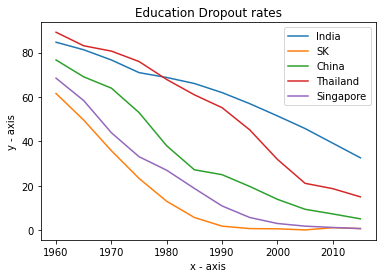

In [50]:
import matplotlib.pyplot as plt

# x axis values
x = years
# corresponding y axis values
edu_drop = pd.read_csv(datasets_path[edu_parameter])
# edu_drop.set_index(["Country"],inplace=True)
edu_drop_india = edu_drop[edu_drop.Country == 'India']
y_india = list(edu_drop_india.values[0][1:])

edu_drop_sk = edu_drop[edu_drop.Country == 'South Korea']
y_sk = list(edu_drop_sk.values[0][1:])

edu_drop_china = edu_drop[edu_drop.Country == 'China']
y_china = list(edu_drop_china.values[0][1:])

edu_drop_tl = edu_drop[edu_drop.Country == 'Thailand']
y_tl = list(edu_drop_tl.values[0][1:])

edu_drop_sing = edu_drop[edu_drop.Country == 'Singapore']
y_sing = list(edu_drop_sing.values[0][1:])

plt.plot(x, y_india,label="India")
plt.plot(x, y_sk,label="SK")
plt.plot(x, y_china,label="China")
plt.plot(x, y_tl,label="Thailand")
plt.plot(x, y_sing,label="Singapore")

 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('Education Dropout rates')
 
# function to show the plot
plt.legend()
plt.show()

[0.07286491601608708, 0.07002602318429148, 0.06718713035249588, 0.06434823752070028, 0.06150934468890468, 0.05867045185710908, 0.05540572510054414, 0.05214099834397919, 0.048876271587414255, 0.04561154483084932, 0.04234681807428437, 0.03938963804116395, 0.03643245800804354, 0.033475277974923126, 0.030518097941802706, 0.02756091790868229, 0.025124201561391064, 0.022687485214099842, 0.020250768866808617, 0.017814052519517395, 0.01537733617222617, 0.013650343032883845, 0.011923349893541522, 0.010196356754199198, 0.008469363614856874, 0.0067423704755145515, 0.005819730305180981, 0.004897090134847411, 0.003974449964513841, 0.0030518097941802705, 0.0021291696238467006, 0.0018689377809321037, 0.0016087059380175072, 0.0013484740951029103, 0.0010882422521883135, 0.0008280104092737168, 0.0008043529690087536, 0.0007806955287437902, 0.0007570380884788268, 0.0007333806482138635, 0.0007097232079489001, 0.0005914360066240834, 0.0004731488052992668, 0.00035486160397445003, 0.0002365744026496334, 0.000

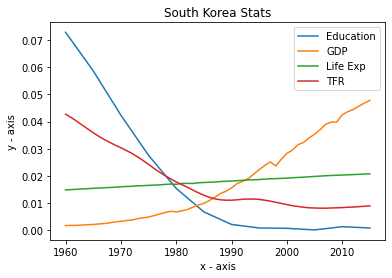

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# x axis values
x = years
# corresponding y axis values
edu_df = pd.read_csv(datasets_path[edu_parameter])
gdp_df = pd.read_csv(datasets_path[gdp_parameter])
le_df  = pd.read_csv(datasets_path[le_parameter])
tfr_df = pd.read_csv(datasets_path[tfr_parameter])

country = 'South Korea'
edu_df = edu_df[edu_df.Country == country]
gdp_df = gdp_df[gdp_df.Country == country]
le_df = le_df[le_df.Country == country]
tfr_df = tfr_df[tfr_df.Country == country]

y_edu = list(edu_df.values[0][1:])
y_gdp = list(gdp_df.values[0][1:])
y_le  = list(le_df.values[0][1:])
y_tfr = list(tfr_df.values[0][1:])

y_edu = [float(i)/sum(y_edu) for i in y_edu]
y_gdp = [float(i)/sum(y_gdp) for i in y_gdp]
y_le = [float(i)/sum(y_le) for i in y_le]
y_tfr = [float(i)/sum(y_tfr) for i in y_tfr]


print(y_edu)
print(y_gdp)
print(y_le)
print(y_tfr)
# print(scaler.fit(y_edu))
# print(scaler.fit(y_gdp))

plt.plot(x, y_edu,label="Education")
plt.plot(x, y_gdp,label="GDP")
plt.plot(x, y_le,label="Life Exp")
plt.plot(x, y_tfr,label="TFR")


# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title(country + ' Stats')
 
# function to show the plot
plt.legend()
plt.show()

76.7
[1.0, 0.9801825293350718, 0.9603650586701433, 0.9405475880052151, 0.9207301173402869, 0.9009126466753584, 0.8876140808344197, 0.8743155149934811, 0.8610169491525425, 0.8477183833116035, 0.8344198174706648, 0.8057366362451107, 0.7770534550195567, 0.7483702737940026, 0.7196870925684485, 0.6910039113428944, 0.651890482398957, 0.6127770534550195, 0.5736636245110821, 0.5345501955671447, 0.4954367666232073, 0.4672750977835724, 0.4391134289439374, 0.41095176010430245, 0.3827900912646675, 0.35462842242503256, 0.3488917861799218, 0.34315514993481094, 0.3374185136897001, 0.3316818774445893, 0.3259452411994785, 0.3121251629726206, 0.29830508474576267, 0.2844850065189048, 0.27066492829204697, 0.25684485006518903, 0.24172099087353321, 0.22659713168187742, 0.21147327249022163, 0.19634941329856584, 0.18122555410691005, 0.1694915254237288, 0.15775749674054756, 0.14602346805736635, 0.13428943937418514, 0.12255541069100391, 0.11707953063885268, 0.11160365058670144, 0.1061277705345502, 0.10065189048

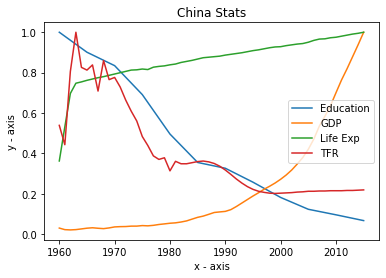

In [73]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# x axis values
x = years
# corresponding y axis values
edu_df = pd.read_csv(datasets_path[edu_parameter])
gdp_df = pd.read_csv(datasets_path[gdp_parameter])
le_df  = pd.read_csv(datasets_path[le_parameter])
tfr_df = pd.read_csv(datasets_path[tfr_parameter])

country = 'China'
edu_df = edu_df[edu_df.Country == country]
gdp_df = gdp_df[gdp_df.Country == country]
le_df = le_df[le_df.Country == country]
tfr_df = tfr_df[tfr_df.Country == country]

y_edu = list(edu_df.values[0][1:])
y_gdp = list(gdp_df.values[0][1:])
y_le  = list(le_df.values[0][1:])
y_tfr = list(tfr_df.values[0][1:])
print(max(y_edu))
y_edu = [float(i)/max(y_edu) for i in y_edu]
y_gdp = [float(i)/max(y_gdp) for i in y_gdp]
y_le = [float(i)/max(y_le) for i in y_le]
y_tfr = [float(i)/max(y_tfr) for i in y_tfr]
print(y_edu)
print(y_gdp)
print(y_le)
print(y_tfr)

# print(scaler.fit(y_edu))
# print(scaler.fit(y_gdp))

plt.plot(x, y_edu,label="Education")
plt.plot(x, y_gdp,label="GDP")
plt.plot(x, y_le,label="Life Exp")
plt.plot(x, y_tfr,label="TFR")


# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title(country + ' Stats')
 
# function to show the plot
plt.legend()
plt.show()

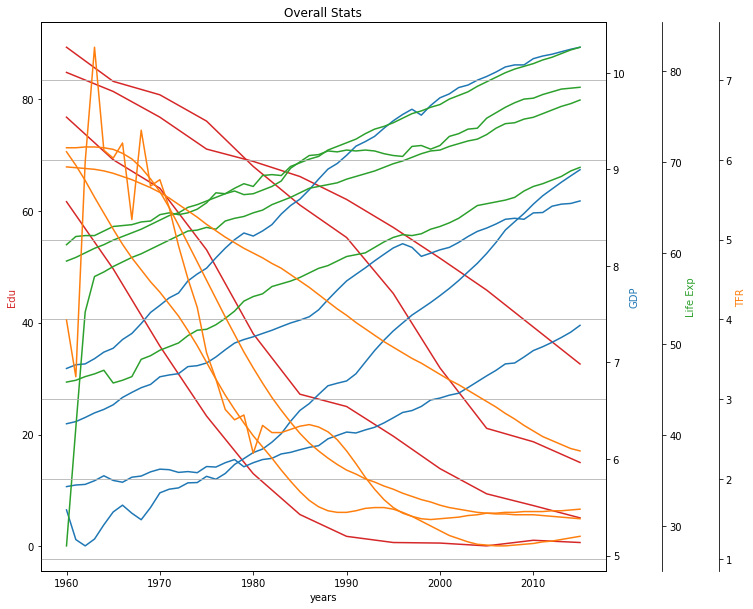

In [117]:

from math import log

# x axis values
x = years
country = ['China','South Korea', 'India', 'Thailand']

fig, ax = plt.subplots()
ax.set_xlabel('years')
ax.set_ylabel("Edu", color="tab:red")

twin1 = ax.twinx()
color = 'tab:blue'
twin1.set_ylabel('GDP', color=color)
twin2 = ax.twinx()
twin2.spines['right'].set_position(('axes', 1.1))
color = 'tab:green'
twin2.set_ylabel('Life Exp', color=color)

twin3 = ax.twinx()
twin3.spines['right'].set_position(('axes', 1.2))
color = 'tab:orange'
twin3.set_ylabel('TFR', color=color)


for c in country:
# corresponding y axis values
  edu_df = pd.read_csv(datasets_path[edu_parameter])
  gdp_df = pd.read_csv(datasets_path[gdp_parameter])
  le_df  = pd.read_csv(datasets_path[le_parameter])
  tfr_df = pd.read_csv(datasets_path[tfr_parameter])

  edu_df = edu_df[edu_df.Country == c]
  gdp_df = gdp_df[gdp_df.Country == c]
  le_df = le_df[le_df.Country == c]
  tfr_df = tfr_df[tfr_df.Country == c]

  y_edu = list(edu_df.values[0][1:])
  y_gdp = list(gdp_df.values[0][1:])
  y_le  = list(le_df.values[0][1:])
  y_tfr = list(tfr_df.values[0][1:])
  y_gdp = [log(x) for x in y_gdp]

  

  
  ax.plot(x,y_edu,label="Edu",color = "tab:red")
  twin1.plot(x, y_gdp,label="GDP", color='tab:blue')
  twin2.plot(x, y_le,label="Life Exp",color='tab:green')
  twin3.plot(x, y_tfr,label="TFR",color='tab:orange')

  
  
plt.title('Overall Stats')


fig.tight_layout()
fig.set_figwidth(12)
fig.set_figheight(10)
plt.grid(axis = 'both')
plt.show()

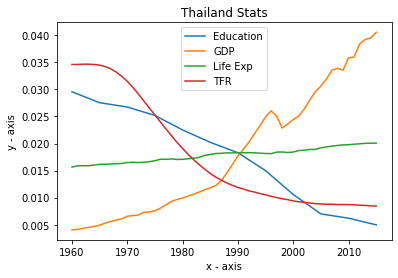

In [68]:

# x axis values
x = years
# corresponding y axis values
edu_df = pd.read_csv(datasets_path[edu_parameter])
gdp_df = pd.read_csv(datasets_path[gdp_parameter])
le_df  = pd.read_csv(datasets_path[le_parameter])
tfr_df = pd.read_csv(datasets_path[tfr_parameter])

country = 'Thailand'
edu_df = edu_df[edu_df.Country == country]
gdp_df = gdp_df[gdp_df.Country == country]
le_df = le_df[le_df.Country == country]
tfr_df = tfr_df[tfr_df.Country == country]

y_edu = list(edu_df.values[0][1:])
y_gdp = list(gdp_df.values[0][1:])
y_le  = list(le_df.values[0][1:])
y_tfr = list(tfr_df.values[0][1:])

y_edu = [float(i)/sum(y_edu) for i in y_edu]
y_gdp = [float(i)/sum(y_gdp) for i in y_gdp]
y_le = [float(i)/sum(y_le) for i in y_le]
y_tfr = [float(i)/sum(y_tfr) for i in y_tfr]
# print(y_edu)
# print(y_gdp)
# print(y_le)
# print(y_tfr)
# print(scaler.fit(y_edu))
# print(scaler.fit(y_gdp))

plt.plot(x, y_edu,label="Education")
plt.plot(x, y_gdp,label="GDP")
plt.plot(x, y_le,label="Life Exp")
plt.plot(x, y_tfr,label="TFR")


# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title(country + ' Stats')
 
# function to show the plot
plt.legend()
plt.show()

# Building Model

In [161]:
datasets = [
            "best_20-24-Primary_OL",
            "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            "best_life_expectancy"
        ]
find_common_countries(datasets)

['thailand', 'china', 'south korea', 'singapore']

### Life Expectancy

#### Preparing the Data

In [181]:
PREDICT_FUTURE  = 0
OUTPUT          = 'best_life_expectancy'

In [192]:
datasets = [
            "best_20-24-Primary_OL",
            "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            # "best_life_expectancy"
            ]
get_countries_count(datasets)

Factor: best_20-24-Primary_OL            count: 22
Factor: best_children_per_woman          count: 19
Factor: best_gdppercapita_us_infla_adjust count: 15


In [193]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [194]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [195]:
input_df            = load_datasets_to_pd(datasets,OUTPUT,keys)
input_df.set_index(["country","year"], inplace=True)
input_df

loading best_20-24-Primary_OL
loading best_children_per_woman
loading best_gdppercapita_us_infla_adjust


,,best_20-24-Primary_OL,best_children_per_woman,best_gdppercapita_us_infla_adjust,o_best_life_expectancy
country,year,,,,
thailand,1960,89.20,6.15,581.0,60.9
south korea,1960,61.60,6.10,1030.0,59.1
china,1960,76.70,3.99,238.0,27.8
singapore,1960,68.50,5.82,3610.0,65.5
thailand,1961,87.98,6.15,594.0,61.8
...,...,...,...,...,...
singapore,2014,0.80,1.25,54700.0,83.8
thailand,2015,15.00,1.50,5840.0,78.2
south korea,2015,0.70,1.28,28700.0,82.6


In [196]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [197]:
input_df

,,best_20-24-Primary_OL,best_children_per_woman,best_gdppercapita_us_infla_adjust
country,year,,,
thailand,1960,89.20,6.15,581.0
south korea,1960,61.60,6.10,1030.0
china,1960,76.70,3.99,238.0
singapore,1960,68.50,5.82,3610.0
thailand,1961,87.98,6.15,594.0
...,...,...,...,...
singapore,2014,0.80,1.25,54700.0
thailand,2015,15.00,1.50,5840.0
south korea,2015,0.70,1.28,28700.0


In [198]:
output_df

,,o_best_life_expectancy
country,year,
thailand,1960,60.9
south korea,1960,59.1
china,1960,27.8
singapore,1960,65.5
thailand,1961,61.8
...,...,...
singapore,2014,83.8
thailand,2015,78.2
south korea,2015,82.6


In [199]:
input_df.isna().sum()

best_20-24-Primary_OL                0
best_children_per_woman              0
best_gdppercapita_us_infla_adjust    0
dtype: int64

In [200]:
input_df.shape

(224, 3)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [206]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmprr8a8s2d as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.093794
Training model
Model trained in 0:00:00.077934
Compiling model
1/1 [==============================] - 0s 123ms/step - loss: 0.0000e+00 - mse: 1.9314
BEST_LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 1.931431770324707}

MSE: 1.931431770324707
RMSE: 1.3897596088261837



In [207]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [208]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	best_20-24-Primary_OL
	best_children_per_woman
	best_gdppercapita_us_infla_adjust

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  5.464371 ################
    2.             "best_20-24-Primary_OL"  3.164541 ########
    3. "best_gdppercapita_us_infla_adjust"  1.350730 #
    4.           "best_children_per_woman"  0.844360 

Variable Importance: NUM_AS_ROOT:
    1.           "best_children_per_woman" 172.000000 ################
    2. "best_gdppercapita_us_infla_adjust" 75.000000 ##
    3.             "best_20-24-Primary_OL" 53.000000 

Variable Importance: NUM_NODES:
    1. "bes

#### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpyj6b7ac5 as temporary training directory
Starting reading the dataset
1/7 [===>..........................] - ETA: 0s
Dataset read in 0:00:00.200345
Training model
Model trained in 0:00:03.003214
Compiling model
7/7 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 0.0018
LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 0.001753112766891718}

MSE: 0.001753112766891718
RMSE: 0.041870189477619016



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	20_yrs_old_gdppercapita_us_infla_adjust
	50__dropout_20-24-Primary_OL_comp
	children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.801453 ################
    2.       "50__dropout_20-24-Primary_OL_comp"  4.705225 ###############
    3.            "gdppercapita_us_infla_adjust"  4.624007 ###############
    4. "20_yrs_old_gdppercapita_us_infla_adjust"  4.570559 ##############


### TFR

#### Preparing the Data

In [209]:
PREDICT_FUTURE  = 0
OUTPUT          = 'best_children_per_woman'

In [210]:
datasets = [
            "best_20-24-Primary_OL",
            # "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            "best_life_expectancy"
            ]
get_countries_count(datasets)

Factor: best_20-24-Primary_OL            count: 22
Factor: best_gdppercapita_us_infla_adjust count: 15
Factor: best_life_expectancy             count: 19


In [211]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [212]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [213]:
input_df            = load_datasets_to_pd(datasets,OUTPUT,keys)
input_df.set_index(["country","year"], inplace=True)
input_df

loading best_20-24-Primary_OL
loading best_gdppercapita_us_infla_adjust
loading best_life_expectancy


,,best_20-24-Primary_OL,best_gdppercapita_us_infla_adjust,best_life_expectancy,o_best_children_per_woman
country,year,,,,
thailand,1960,89.20,581.0,60.9,6.15
china,1960,76.70,238.0,27.8,3.99
south korea,1960,61.60,1030.0,59.1,6.10
singapore,1960,68.50,3610.0,65.5,5.82
thailand,1961,87.98,594.0,61.8,6.15
...,...,...,...,...,...
singapore,2014,0.80,54700.0,83.8,1.25
thailand,2015,15.00,5840.0,78.2,1.50
china,2015,5.10,8070.0,76.8,1.62


In [214]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [215]:
input_df

,,best_20-24-Primary_OL,best_gdppercapita_us_infla_adjust,best_life_expectancy
country,year,,,
thailand,1960,89.20,581.0,60.9
china,1960,76.70,238.0,27.8
south korea,1960,61.60,1030.0,59.1
singapore,1960,68.50,3610.0,65.5
thailand,1961,87.98,594.0,61.8
...,...,...,...,...
singapore,2014,0.80,54700.0,83.8
thailand,2015,15.00,5840.0,78.2
china,2015,5.10,8070.0,76.8


In [216]:
output_df

,,o_best_children_per_woman
country,year,
thailand,1960,6.15
china,1960,3.99
south korea,1960,6.10
singapore,1960,5.82
thailand,1961,6.15
...,...,...
singapore,2014,1.25
thailand,2015,1.50
china,2015,1.62


In [217]:
input_df.isna().sum()

best_20-24-Primary_OL                0
best_gdppercapita_us_infla_adjust    0
best_life_expectancy                 0
dtype: int64

In [218]:
input_df.shape

(224, 3)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [220]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmp5witoke7 as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.106593
Training model
Model trained in 0:00:00.073343
Compiling model
1/1 [==============================] - 0s 126ms/step - loss: 0.0000e+00 - mse: 0.0855
BEST_CHILDREN_PER_WOMAN
{'loss': 0.0, 'mse': 0.0855288878083229}

MSE: 0.0855288878083229
RMSE: 0.29245322328249845



In [221]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [222]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	best_20-24-Primary_OL
	best_gdppercapita_us_infla_adjust
	best_life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  5.838136 ################
    2. "best_gdppercapita_us_infla_adjust"  3.981217 ##########
    3.             "best_20-24-Primary_OL"  1.297731 ##
    4.              "best_life_expectancy"  0.501088 

Variable Importance: NUM_AS_ROOT:
    1.              "best_life_expectancy" 204.000000 ################
    2.             "best_20-24-Primary_OL" 94.000000 #######
    3. "best_gdppercapita_us_infla_adjust"  2.000000 

Variable Importance: NUM_NODES:
    1.

#### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpyj6b7ac5 as temporary training directory
Starting reading the dataset
1/7 [===>..........................] - ETA: 0s
Dataset read in 0:00:00.200345
Training model
Model trained in 0:00:03.003214
Compiling model
7/7 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 0.0018
LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 0.001753112766891718}

MSE: 0.001753112766891718
RMSE: 0.041870189477619016



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	20_yrs_old_gdppercapita_us_infla_adjust
	50__dropout_20-24-Primary_OL_comp
	children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.801453 ################
    2.       "50__dropout_20-24-Primary_OL_comp"  4.705225 ###############
    3.            "gdppercapita_us_infla_adjust"  4.624007 ###############
    4. "20_yrs_old_gdppercapita_us_infla_adjust"  4.570559 ##############


### Education

#### Preparing the Data

In [223]:
PREDICT_FUTURE  = 0
OUTPUT          = 'best_20-24-Primary_OL'

In [224]:
datasets = [
            # "best_20-24-Primary_OL",
            "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            "best_life_expectancy"
            ]
get_countries_count(datasets)

Factor: best_children_per_woman          count: 19
Factor: best_gdppercapita_us_infla_adjust count: 15
Factor: best_life_expectancy             count: 19


In [225]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [226]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [227]:
input_df            = load_datasets_to_pd(datasets,OUTPUT,keys)
input_df.set_index(["country","year"], inplace=True)
input_df

loading best_children_per_woman
loading best_gdppercapita_us_infla_adjust
loading best_life_expectancy


,,best_children_per_woman,best_gdppercapita_us_infla_adjust,best_life_expectancy,o_best_20-24-Primary_OL
country,year,,,,
thailand,1960,6.15,581.0,60.9,89.20
china,1960,3.99,238.0,27.8,76.70
south korea,1960,6.10,1030.0,59.1,61.60
singapore,1960,5.82,3610.0,65.5,68.50
thailand,1961,6.15,594.0,61.8,87.98
...,...,...,...,...,...
singapore,2014,1.25,54700.0,83.8,0.80
thailand,2015,1.50,5840.0,78.2,15.00
china,2015,1.62,8070.0,76.8,5.10


In [228]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [229]:
input_df

,,best_children_per_woman,best_gdppercapita_us_infla_adjust,best_life_expectancy
country,year,,,
thailand,1960,6.15,581.0,60.9
china,1960,3.99,238.0,27.8
south korea,1960,6.10,1030.0,59.1
singapore,1960,5.82,3610.0,65.5
thailand,1961,6.15,594.0,61.8
...,...,...,...,...
singapore,2014,1.25,54700.0,83.8
thailand,2015,1.50,5840.0,78.2
china,2015,1.62,8070.0,76.8


In [230]:
output_df

,,o_best_20-24-Primary_OL
country,year,
thailand,1960,89.20
china,1960,76.70
south korea,1960,61.60
singapore,1960,68.50
thailand,1961,87.98
...,...,...
singapore,2014,0.80
thailand,2015,15.00
china,2015,5.10


In [231]:
input_df.isna().sum()

best_children_per_woman              0
best_gdppercapita_us_infla_adjust    0
best_life_expectancy                 0
dtype: int64

In [232]:
input_df.shape

(224, 3)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [234]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmp3_rbausj as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.112334
Training model
Model trained in 0:00:00.124044
Compiling model
1/1 [==============================] - 0s 139ms/step - loss: 0.0000e+00 - mse: 21.4489
BEST_20-24-PRIMARY_OL
{'loss': 0.0, 'mse': 21.4488525390625}

MSE: 21.4488525390625
RMSE: 4.631290591083926



In [235]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [236]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	best_children_per_woman
	best_gdppercapita_us_infla_adjust
	best_life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  5.350935 ################
    2.              "best_life_expectancy"  2.424457 ######
    3. "best_gdppercapita_us_infla_adjust"  2.348980 ######
    4.           "best_children_per_woman"  0.472566 

Variable Importance: NUM_AS_ROOT:
    1.           "best_children_per_woman" 212.000000 ################
    2.              "best_life_expectancy" 69.000000 ####
    3. "best_gdppercapita_us_infla_adjust" 19.000000 

Variable Importance: NUM_NODES:
    1. 

#### Gradient Tree

In [237]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpcgozjfv4 as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.135211
Training model
Model trained in 0:00:00.339765
Compiling model
1/1 [==============================] - 0s 495ms/step


1/1 [==============================] - 0s 155ms/step - loss: 0.0000e+00 - mse: 2.8986
BEST_20-24-PRIMARY_OL
{'loss': 0.0, 'mse': 2.898608446121216}

MSE: 2.898608446121216
RMSE: 1.702530013280593



In [238]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [239]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	best_children_per_woman
	best_gdppercapita_us_infla_adjust
	best_life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  3.981581 ################
    2.              "best_life_expectancy"  1.640411 #
    3. "best_gdppercapita_us_infla_adjust"  1.521010 
    4.           "best_children_per_woman"  1.402811 

Variable Importance: NUM_AS_ROOT:
    1.           "best_children_per_woman" 141.000000 ################
    2.              "best_life_expectancy" 76.000000 ##
    3. "best_gdppercapita_us_infla_adjust" 63.000000 

Variable Importance: NUM_NODES:
    

### GDP

#### Preparing the Data

In [347]:
PREDICT_FUTURE  = 0
OUTPUT          = 'gdppercapita_us_infla_adjust'

In [348]:
datasets = [
            # "infant_mortality",
            # "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            "gini_index",
            create_n_yrs_old_csv("infant_mortality",n = 20),
            # create_n_yrs_old_csv("life_expectancy",n = 20),
            # create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("20-24-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24-Primary_OL",n = 20),
            create_n_yrs_old_csv("20-24-Lower_Secondary_OL",n = 20),
            # create_n_yrs_old_csv("20-24_female-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24_female-Primary_OL",n = 20),
            # "gdp_growth",
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # rate_of_dropout("20-24-Primary_OL",5),
            # "20-24-In_Primary_OL",
            # "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: gini_index                       count: 195
Factor: 20_yrs_old_infant_mortality      count: 266
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: 20_yrs_old_20-24-Lower_Secondary_OL count: 202
Factor: population                       count: 197


In [366]:
# creating a list of all countries & years
countries = ['china', 'singapore', 'south korea', 'thailand']
years     = [y for y in range(1980,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [350]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [367]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True)
input_df

loading gini_index
loading 20_yrs_old_infant_mortality
loading 20_yrs_old_children_per_woman
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading 20_yrs_old_20-24-Lower_Secondary_OL
loading population


,,gini_index,20_yrs_old_infant_mortality,20_yrs_old_children_per_woman,20_yrs_old_gdppercapita_us_infla_adjust,20_yrs_old_20-24-Lower_Secondary_OL,population,o_gdppercapita_us_infla_adjust
country,year,,,,,,,
china,1980,24.5,NaN,3.99,238.0,97.1,1.000000e+09,431.0
singapore,1980,33.0,35.4,5.82,3610.0,90.0,2.410000e+06,13900.0
south korea,1980,39.0,79.7,6.10,1030.0,83.3,3.800000e+07,4060.0
thailand,1980,44.8,101.3,6.15,581.0,98.4,4.740000e+07,1430.0
china,1981,24.8,NaN,3.28,175.0,96.7,1.010000e+09,447.0
...,...,...,...,...,...,...,...,...
thailand,2014,37.2,24.9,1.91,3360.0,66.6,6.840000e+07,5690.0
china,2015,39.4,37.7,1.64,1520.0,74.6,1.410000e+09,8070.0
singapore,2015,40.9,4.0,1.67,30400.0,14.7,5.590000e+06,55600.0


In [368]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [369]:
input_df

,,gini_index,20_yrs_old_infant_mortality,20_yrs_old_children_per_woman,20_yrs_old_gdppercapita_us_infla_adjust,20_yrs_old_20-24-Lower_Secondary_OL,population
country,year,,,,,,
china,1980,24.5,NaN,3.99,238.0,97.1,1.000000e+09
singapore,1980,33.0,35.4,5.82,3610.0,90.0,2.410000e+06
south korea,1980,39.0,79.7,6.10,1030.0,83.3,3.800000e+07
thailand,1980,44.8,101.3,6.15,581.0,98.4,4.740000e+07
china,1981,24.8,NaN,3.28,175.0,96.7,1.010000e+09
...,...,...,...,...,...,...,...
thailand,2014,37.2,24.9,1.91,3360.0,66.6,6.840000e+07
china,2015,39.4,37.7,1.64,1520.0,74.6,1.410000e+09
singapore,2015,40.9,4.0,1.67,30400.0,14.7,5.590000e+06


In [370]:
output_df

,,o_gdppercapita_us_infla_adjust
country,year,
china,1980,431.0
singapore,1980,13900.0
south korea,1980,4060.0
thailand,1980,1430.0
china,1981,447.0
...,...,...
thailand,2014,5690.0
china,2015,8070.0
singapore,2015,55600.0


In [371]:
input_df.isna().sum()

gini_index                                 0
20_yrs_old_infant_mortality                9
20_yrs_old_children_per_woman              0
20_yrs_old_gdppercapita_us_infla_adjust    0
20_yrs_old_20-24-Lower_Secondary_OL        0
population                                 0
dtype: int64

In [343]:
input_df.shape

(144, 3)

In [372]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [378]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpu85d9nfi as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.319288
Training model
Model trained in 0:00:00.164369
Compiling model
1/1 [==============================] - 1s 578ms/step


Evaluation(num_examples=144, accuracy=None, loss=None, rmse=1719.1420060416235, ndcg=None, aucs=None)

In [346]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [379]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	20_yrs_old_20-24-Lower_Secondary_OL
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	20_yrs_old_infant_mortality
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  5.155842 ################
    2.           "20_yrs_old_children_per_woman"  4.435326 #############
    3.                              "gini_index"  4.030521 ###########
    4.                              "population"  3.412205 ########
    5.     "20_yrs_old_20-24-Lower_Secondary_OL"  2.946930 #######
    6.             "20_yrs_old_infant_mortality"  2.567235 #####
 

#### Gradient Tree

In [375]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpqxxs3yem as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.173170
Training model
Model trained in 0:00:00.158935
Compiling model
1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 185ms/step - loss: 0.0000e+00 - mse: 939368.2500
GDPPERCAPITA_US_INFLA_ADJUST
{'loss': 0.0, 'mse': 939368.25}

MSE: 939368.25
RMSE: 969.2101165382045



In [376]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [377]:
model.summary()

Model: "gradient_boosted_trees_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	20_yrs_old_20-24-Lower_Secondary_OL
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	20_yrs_old_infant_mortality
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  3.851117 ################
    2.                              "gini_index"  3.110536 ##########
    3.           "20_yrs_old_children_per_woman"  3.066411 ##########
    4.             "20_yrs_old_infant_mortality"  3.044838 ##########
    5.                              "population"  2.797885 ########
    6.     "20_yrs_old_20-24-Lower_Secondary_OL" 

# Save the summary

In [328]:
#@markdown What changes you made to datasets & why ?


approach = 'built model using only top 5 factors '  #@param {type: "string"}


In [329]:
inspector = model.make_inspector()

In [330]:
model_name = inspector.model_type()
num_trees  = inspector.num_trees()
objective  = inspector.objective()
eval = inspector.evaluation()

In [331]:

input_features_list = inspector.features()
input_features = ""
for i in range(len(input_features_list)):
  input_features += str(i+1)+ "  "
  input_features += input_features_list[i][0] + "\n"

In [332]:
variable_imp = []
variable_imp.append(extract_variable_imp(variable = 'MEAN_MIN_DEPTH'))
variable_imp.append(extract_variable_imp(variable = 'SUM_SCORE'))


In [333]:
#@ Analysis
#@markdown Observations made from the output ?


anaylsis = 'The error rate is pretty bad'  #@param {type: "string"}


In [334]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [335]:
with open('/content/drive/My Drive/education-impact/crct-document.txt', 'a') as f:
  f.write("Model Trained : " + model_name+ "\n")
  f.write("Predicting : " + OUTPUT + "\n")
  f.write("Approach : " + approach + "\n")
  f.write("Num Examples: " + str(eval.num_examples) + "\n\n")
  f.write("Input Features\n")
  f.write(input_features+"\n\n")
  f.write("Model Performance\n")
  f.write("RMSE Score : "  + str(eval.rmse)+ "\n\n")
  for v in variable_imp:
    f.write(v + "\n\n")
  f.write("Analysis : " + anaylsis + "\n")
  f.write("\n\n\n")

  

# Models to try
 - RandomForestModel
 - GradientBoostedTreesModel
 - CartModel
 - DistributedGradientBoostedTreesModel

 - KNN Regression
 - Support Vector Regression
 - Locally Weighted Scatterplot Smoothing
 - Multivariate Adaptive Regression Splines
  

In [313]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]